In [1]:
from datetime import datetime
import tensorflow as tf
import importlib
import numpy as np
import pandas as pd


In [100]:
# import config 
import configs.config
importlib.reload(configs.config)
from configs.config import CFG
from utils import config
config = config.Config.from_json(CFG)

## Create Dataset

In [101]:
# create Train Series and Dataset 
import dataloader.dataloader
importlib.reload(dataloader.dataloader)
from dataloader.dataloader import Train_Series,Dataset
try: 
    del series,ds
except:
    pass
from dataloader.dataloader import Test_Series
try: 
    del test_series
except:
    pass

series = Train_Series(config.data,config.paths)
series.createSeries()
test_series = Test_Series(config.data,config.paths)
test_series.createSeries()
ds = Dataset(series,test_series)
ds.split_dataset()

X_train = ds.X_train
y_train = ds.y_train
X_test = ds.X_test
y_test = ds.y_test

print(X_train.shape)
print(X_test.shape)


(5685, 160, 2)
(3, 160, 2)


## Save Datset to Files 

In [4]:
# import pickle
# # Include the epoch in the file name (uses `str.format`)
# ds_path = "./model/saved_ds/ds.obj"

# with  open(ds_path,'wb') as file:
#     exampleObj = pickle.dump(ds,file)


## Call model and compile

In [127]:
from model.model1D import Unet,Unet_Model
import model.model1D
importlib.reload(model.model1D)
try: 
    del unet
except:
    pass

unet = Unet(n_classes=3,n_filters=16)
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)
unet.model((160,2)).summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 2)]     0           []                               
                                                                                                  
 downsampling_block_20 (Downsam  ((None, 80, 16),    896         ['input_5[0][0]']                
 plingBlock)                     (None, 160, 16))                                                 
                                                                                                  
 downsampling_block_21 (Downsam  ((None, 40, 32),    4672        ['downsampling_block_20[0][0]']  
 plingBlock)                     (None, 80, 32))                                                  
                                                                                            

## Train Model and save weights and model to files

In [128]:
from datetime import datetime
#train model
history = unet.fit(X_train,y_train,epochs = 15,batch_size = 64)




Epoch 1/15
89/89 [==============================] - 20s 225ms/step - loss: 0.5749 - accuracy: 0.7334
Epoch 2/15
89/89 [==============================] - 20s 219ms/step - loss: 0.3391 - accuracy: 0.9026
Epoch 3/15
89/89 [==============================] - 19s 211ms/step - loss: 0.3052 - accuracy: 0.9078
Epoch 4/15
89/89 [==============================] - 19s 219ms/step - loss: 0.2390 - accuracy: 0.9187
Epoch 5/15
89/89 [==============================] - 20s 223ms/step - loss: 0.2439 - accuracy: 0.9137
Epoch 6/15
89/89 [==============================] - 20s 230ms/step - loss: 0.2231 - accuracy: 0.9224
Epoch 7/15
89/89 [==============================] - 20s 224ms/step - loss: 0.2138 - accuracy: 0.9242
Epoch 8/15
89/89 [==============================] - 19s 218ms/step - loss: 0.2137 - accuracy: 0.9237
Epoch 9/15
89/89 [==============================] - 20s 221ms/step - loss: 0.2056 - accuracy: 0.9272
Epoch 10/15
89/89 [==============================] - 20s 230ms/step - loss: 0.2036 - accura

In [7]:
# # Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "model/weights/cp-{epoch:04d}.ckpt"
# # save weights 
# unet.save_weights(checkpoint_path.format(epoch=100))
# #save model
# models_path = "model/saved_models/unet_{version}_{now}"
# unet.save(models_path.format(version = "v1", now = str(datetime.now().date())))

In [8]:
# # Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "model/weights/cp-{epoch:04d}.ckpt"

# # Loads the weights
# unet.load_weights(checkpoint_path.format(epoch =100))

# # Re-evaluate the model
# # loss, acc = unet.evaluate(test_images, test_labels, verbose=2)
# # print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [129]:
def create_events(serie,y_pred :np.array):
    """create df_events 
    input:
    y_pred - score  (predicited vaues )"""
    def detectChange(last_val,current_val):
        if last_val == -1 or current_val == -1:
            return False

        return last_val !=current_val

    # create empty dataframe
    df_events = pd.DataFrame(columns=["series_id","step","event","score"])
    # unpad y_pred
    if serie.slice_pads is None:
        y_pred_unpadded = y_pred
    else:
        y_pred_unpadded = serie._unpad(y_pred,serie.slice_pads)
    # create step seg list
    #         - events - segmentation mask
    #         -  score   - predicited vaues for chosen event
    events = np.argmax(y_pred_unpadded,axis = -1,keepdims=True)
    scores = np.max(y_pred_unpadded,axis=-1,keepdims=True)      


    for slices_num in range(events.shape[0]):
        slice = events[slices_num]
        score = scores[slices_num]
        for i in range(events.shape[1]):
            event_val = slice[i][0]
            event_score = score[i][0]

            if i == 0:
                # do not detect anything during first step
                continue
            elif not detectChange(slice[i-1],event_val):
                continue

            df_events.loc[len(df_events.index)] = [serie.serie_id,i,event_val,event_score]

    # decode events 
    decoded_list = {v: k for k, v in serie.__class__.decode_list.items()}
    df_events["event"] = df_events["event"].map(decoded_list)  
    # df_events = serie.decode_events(df_events)
    # save as serie events 
    return df_events 

In [130]:
def predict(model,serie):
    x = serie.get_correct_slices()
    x = x[...,:-1]
    try:
        y_pred = model.predict(x)
    except ValueError:
        print(x.shape)
        print(x)
        print(y_pred)
        
    # print(y_pred.shape)
    #print(y_pred)
    serie_events = create_events(serie, y_pred)   
    return serie_events

## Validation with train set

In [133]:
## 

series_pred = {}
y_pred = None
pred_start = False
for serie_id, serie in series.series.items():
    print(serie_id)
    serie_events = predict(unet,serie)

    if pred_start == False:
        y_pred = serie_events
        pred_start = True
    else:
        y_pred = pd.concat([y_pred, serie_events])

print(y_pred)

03d92c9f6f8a
3/3 [==============================] - 0s 40ms/step
04f547b8017d
7/7 [==============================] - 0s 38ms/step
05e1944c3818
3/3 [==============================] - 0s 37ms/step
1b92be89db4c
7/7 [==============================] - 0s 40ms/step
1c7c0bad1263
2/2 [==============================] - 0s 66ms/step
1d4569cbac0f
4/4 [==============================] - 0s 37ms/step
1e6717d93c1d
2/2 [==============================] - 0s 38ms/step
1f96b9668bdf
5/5 [==============================] - 0s 40ms/step
2b0a1fa8eba8
7/7 [==============================] - 0s 39ms/step
2b8d87addea9
9/9 [==============================] - 0s 42ms/step
2cd2340ca14d
4/4 [==============================] - 0s 41ms/step
2e9ced2c7976
4/4 [==============================] - 0s 39ms/step
2f7504d0f426
6/6 [==============================] - 0s 39ms/step
2fbbee1a38e3
7/7 [==============================] - 0s 39ms/step
2fc653ca75c7
(0,)
[]


UnboundLocalError: local variable 'y_pred' referenced before assignment

train accuracy : 0.9564409368635438


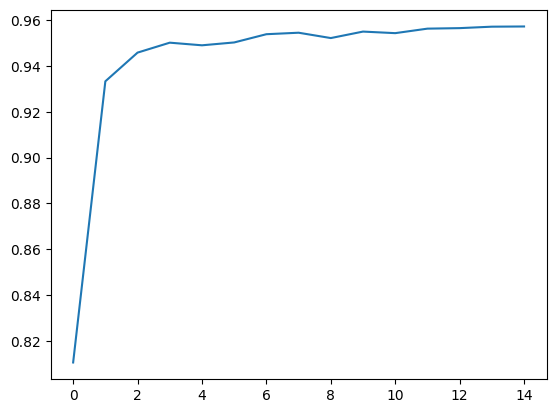

In [52]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"])

def accuracy(real,pred):
    comp = real == pred

    return np.sum(comp)/(real.shape[0]*real.shape[1])

arg = np.expand_dims(np.argmax(y_dev_pred,axis = -1),axis = -1)
print("train accuracy : " + str(accuracy(y_dev,arg)))



In [76]:
def create_events(serie,y_pred :np.array):
    """create df_events 
    input:
    y_pred - score  (predicited vaues )"""
    def detectChange(last_val,current_val):
        if last_val == -1 or current_val == -1:
            return False

        return last_val !=current_val

    # create empty dataframe
    df_events = pd.DataFrame(columns=["series_id","step","event","score"])
    # unpad y_pred
    if serie.slice_pads is None:
        y_pred_unpadded = y_pred
    else:
        y_pred_unpadded = serie._unpad(y_pred,serie.slice_pads)
    # create step seg list
    #         - events - segmentation mask
    #         -  score   - predicited vaues for chosen event
    events_nonpadding =np.argmax(y_pred,axis = -1,keepdims=True)
    events = np.argmax(y_pred_unpadded,axis = -1,keepdims=True)
    score = np.max(y_pred_unpadded,axis=-1,keepdims=True)      
    


    sum1 = 0
    sum2 = 0
    for i in range(events.shape[0]):
        event_val = events[i]
        event_score = score[i]
        if i == 0:
            # do not detect anything during first step
            continue
        elif not detectChange(events[i-1],event_val):
            continue
        print(i)
        if (events[i,:,2] == 2).any() and (events[i,:,2] == 1).any():
            print(f"events  {i}")

        if (events_nonpadding [i,:,2] == 2).any() and (events_nonpadding [i,:,2] == 1).any():
            print(f"events_nonpadding {i}")

        df_events.loc[len(df_events.index)] = [serie.serie_id,i,event_val,event_score]


        sum1 = sum1 + np.sum(events_nonpadding[i,:,2]==1)
        sum2 = sum2 + np.sum(events_nonpadding[i,:,2]==2)
    # decode events 

    df_events = serie.decode_events(df_events)

    # # save as serie events 
    # serie.serie_events = df_events

    return df_events

In [ ]:
def create__dev_events(serie,y_pred :np.array):
    """create df_events 
    input:
    y_pred - score  (predicited vaues )"""
    def detectChange(last_val,current_val):
        if last_val == -1 or current_val == -1:
            return False

        return last_val !=current_val

    # create empty dataframe
    df_events = pd.DataFrame(columns=["series_id","step","event","score"])
    # create step seg list
    #         - events - segmentation mask
    #         -  score   - predicited vaues for chosen event
    events_nonpadding =np.argmax(y_pred,axis = -1,keepdims=True)
    events = np.argmax(y_pred,axis = -1,keepdims=True)
    score = np.max(y_pred,axis=-1,keepdims=True)      
    


    sum1 = 0
    sum2 = 0
    for i in range(events.shape[0]):
        event_val = events[i]
        print(event_val)
        event_score = score[i]
        if i == 0:
            # do not detect anything during first step
            continue
        elif not detectChange(events[i-1],event_val):
            continue
        
        if (events[i,:,2] == 2).any() and (events[i,:,2] == 1).any():
            print(i)

        if (events_nonpadding [i,:,2] == 2).any() and (events_nonpadding [i,:,2] == 1).any():
            print(f"events_nonpadding {i}")

        df_events.loc[len(df_events.index)] = ["serie_id",i,event_val,event_score]


        sum1 = sum1 + np.sum(events_nonpadding[i,:,2]==1)
        sum2 = sum2 + np.sum(events_nonpadding[i,:,2]==2)
    # decode events 
    df_events = serie.decode_events(df_events)

    print(f"sum1 : {sum1}")
    print(f"sum2 : {sum2}")
    # # save as serie events 
    # serie.serie_events = df_events

    return df_events
y_pred = y_dev_pred
serie_events_added = None
pred_start = False
for i in range(y_pred.shape[0]):
    serie_events = create_events(serie,y_pred[[i]])   
    if pred_start == False:
        serie_events_added = serie_events
        pred_start = True
    else:
        serie_events_added = pd.concat([serie_events_added, serie_events])
 serie_events_added

In [75]:
def predict(model,serie):
    x = serie.get_correct_slices()
    x = x[:,:,:-1]
    #print(x)

    y_pred = model.predict(x)
    #print(y_pred)
    #print(y_pred)
    serie_events_added = None
    pred_start = False
    for i in range(y_pred.shape[0]):
        serie_events = create_events(serie,y_pred[[i]])   
        if pred_start == False:
            serie_events_added = serie_events
            pred_start = True
        else:
            serie_events_added = pd.concat([serie_events_added, serie_events])
    return serie_events_added


series_pred = {}
y_pred = None
pred_start = False
for serie_id, serie in series.series.items():
    print(serie_id)
    serie_events = predict(unet,serie)
    #print(serie_events)
    if pred_start == False:
        y_pred = serie_events
        pred_start = True
    else:
        y_pred = pd.concat([y_pred, serie_events])
    print(y_pred)


03d92c9f6f8a
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 9ms/step
[[1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
[[1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]
 [2]
 [2

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [93]:
def create_events(serie,y_pred :np.array):
    """create df_events 
    input:
    y_pred - score  (predicited vaues )"""
    def detectChange(last_val,current_val):
        if last_val == -1 or current_val == -1:
            return False

        return last_val !=current_val

    # create empty dataframe
    df_events = pd.DataFrame(columns=["series_id","step","event","score"])
    # unpad y_pred
    if serie.slice_pads is None:
        y_pred_unpadded = y_pred
    else:
        y_pred_unpadded = serie._unpad(y_pred,serie.slice_pads)
    # create step seg list
    #         - events - segmentation mask
    #         -  score   - predicited vaues for chosen event
    events = np.argmax(y_pred_unpadded,axis = -1,keepdims=True)
    scores = np.max(y_pred_unpadded,axis=-1,keepdims=True)      

    for slices_num in range(events.shape[0]):
        slice = events[slices_num]
        score = scores[slices_num]
        for i in range(events.shape[1]):
            event_val = slice[i]
            event_score = score[i]
            if i == 0:
                # do not detect anything during first step
                continue
            elif not detectChange(slice[i-1],event_val):
                continue

            df_events.loc[len(df_events.index)] = [serie.serie_id,i,event_val,event_score]
    # decode events 
    print(type(df_events))
    df_events = serie.decode_events(df_events)

    # # save as serie events 
    # serie.serie_events = df_events

    return df_events


def predict(model,serie):
    x = serie.get_correct_slices()
    x = x[:,:,:-1]
    #print(x)

    y_pred = model.predict(x)
    serie_events = create_events(serie,y_pred)   

    return serie_events


serie = series.series["03d92c9f6f8a"]
serie_id = "03d92c9f6f8a"

series_pred = {}
y_pred = None
pred_start = False

print(serie_id)
serie_events = predict(unet,serie)
print(y_pred)


03d92c9f6f8a
3/3 [==============================] - 0s 7ms/step
<class 'pandas.core.frame.DataFrame'>


TypeError: unhashable type: 'numpy.ndarray'

In [95]:
def predict(model,test_serie):
    example = test_serie.serie[["anglez","enmo"]].to_numpy()
    x = ds._transform(example)
    #print(example)
    #x = np.concatenate([np.full(shape=(5,2),fill_value=x[0]),x[:],np.full(shape=(5,2),fill_value=x[-1])])
    #x = np.expand_dims(x,axis =0)
    y_pred1 = model.predict(np.expand_dims(x[:128],axis =0))
    y_pred2 = model.predict(np.expand_dims(x[22:],axis =0))
    #print(y_pred1.shape,y_pred2.shape)
    y_pred = np.concatenate([y_pred1[0,:22],(y_pred1[0,22:128]+y_pred2[0,22:128])/2,y_pred2[0,128:]])
    y_pred = np.expand_dims(y_pred,axis =0)
    #print(y_pred.shape)
    #print(y_pred)
    print(y_pred.shape)
    serie_events = test_serie.create_events(y_pred)   
    return serie_events

series_pred = {}
y_pred = None
pred_start = False
for serie_id, serie in test_series.series.items():
    print(serie_id)
    serie_events = predict(unet,serie)
    #print(serie_events)
    if pred_start == False:
        y_pred = serie_events
        pred_start = True
    else:
        y_pred = pd.concat([y_pred, serie_events])

print(y_pred)

038441c925bb
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 27ms/step
(1, 128, 3)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

734/734 [==============================] - 4s 5ms/step
train accuracy : 0.0
1/1 [==============================] - 0s 20ms/step
test accuracy : 0.0


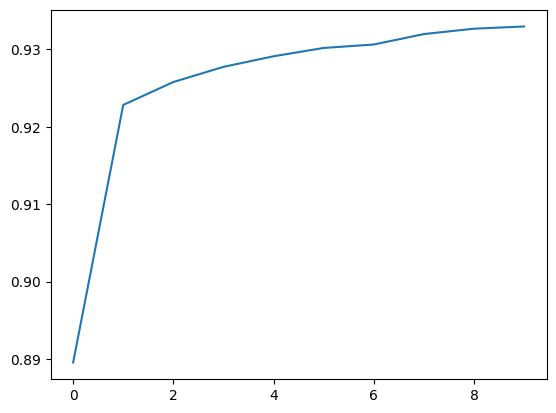

In [10]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"])

def accuracy(real,pred):
    comp = real == pred
    return np.sum(comp)/(comp.shape[0]*comp.shape[1])


y_train_pred = unet.predict(X_train)
print("train accuracy : " + str(accuracy(y_train,y_train_pred)))


y_test_pred = unet.predict(X_test)
print("test accuracy : " +  str(accuracy(y_test,y_test_pred)))

In [12]:
# from IPython.display import FileLink
# import pandas as pd

# # import os
# # os.chdir(r'kaggle/working')'
# filename = 'train_' +'.csv'
# pd.DataFrame(test_mask).to_csv(filename)

# FileLink(filename)



In [114]:
encode_list = {
        "unknown":0,
        "awake":1,
        "onset":2,
        "sleep":2,
        "wakeup":1
    }

def _pad_to(x, step_window):
    """
    x - data which requires padding
    step_window - amount of steps to which "x" has to be padded"""
    Ni, h,w = x.shape[:-2], x.shape[-2],x.shape[-1]
    pads = (step_window - h)//2
    shape = (*Ni,step_window,w)
    out = np.zeros(shape=shape)
    if len(Ni) == 0:
        out[pads:(step_window-pads)] = x
    else:
        for ii in np.ndindex(Ni):
            x_j = 0
            for jj in range(pads,(step_window-5)):
                out_j = (jj,)
                out[ii+out_j] = x[ii+(x_j,)]
                x_j+=1
        #out[Ni,pads:(final_length-5)] = x
    return out, pads

def _unpad(x, pad):
    """
    x - data which requires unpadding
    pad - amount of pads from every side of data (at the beginning and at the end)
    """
    Ni, h,w = x.shape[:-2], x.shape[-2],x.shape[-1]

    if len(Ni) == 0:
        return x[pad:(h-pad)]
    else:
        shape = (*Ni,h-pad*2,w)
        out = np.zeros(shape=shape)
        for ii in np.ndindex(Ni):
            out_j= 0 
            for jj in range(pad,(x.shape[-2]-pad)):
                out[ii+(out_j,)]= x[ii+(jj,)]
                out_j +=1
        return out

def _detect_change(slice):
    for val in encode_list.values():
        if (slice[0,:,-1] == val).all():
            return False
    return True 

def create_slices(step_window, drop_columns,serie,limit_slices = False, limit_window = 10):
    """ create slices from the serie 
    step_window - defines how many steps contains every slice
    drop_columns - columns to be dropped 
    serie - serie to be sliced
    limit_slices = limit series slicing only to specific slices sets - every set contains an event change within limit window (func argument)
    """



    # if series length is too short - there will be only one slice which needs to be padded 
    if step_window > len(serie):
        # calculate slice lenght 
        data = serie.drop(columns =drop_columns)
        slices = np.expand_dims(data,axis =0)
        slices, slice_pads = _pad_to(slices,step_window)

    else:    
        # calculate slice columns after dropping
        slice_columns = len(serie.columns) - len(drop_columns)
        slices_num = len(serie)//step_window
        # aug_offsets = 0
        # if .augmentation:
        #     aug_offsets = np.random.random_integers(low=-time_window+1,high=time_window-1,size=slices_num)
        
        # init variables
        slices = np.array([]) 
        new_slices = np.array([])
        slice_pos = 0 
        slice_expected_pos =0 
        wait_for_position = False

        for i in range(slices_num):
            # cut slice
            slice = serie[(serie['step'] < step_window+step_window*i) & (serie['step']  >= step_window*i) ]    
            new_slice  =slice.drop(columns =drop_columns).to_numpy()
            
            if limit_slices: 
                
                new_slice = np.expand_dims(new_slice,axis =0)
                if len(new_slices) == 0:
                    new_slices = new_slice
                elif len(new_slices) <limit_window:
                    new_slices = np.concatenate((new_slices,new_slice),axis = 0)
                else:
                    new_slices = np.concatenate((new_slices[1:limit_window+1],new_slice),axis = 0)

                slice_pos = slice_pos - 1 
                
                # update position if slice is with an event change 
                if _detect_change(new_slice):
                    # set random position for slice with detected change
                    slice_expected_pos = np.random.randint(0,limit_window-1)
                    wait_for_position =True
                    slice_pos = new_slices.shape[0]

                
                if wait_for_position and slice_pos == slice_expected_pos:
                    if len(slices) ==0 : 
                        slices = new_slices
                    else:
                        slices = np.concatenate((slices,new_slices),axis =0)
                    wait_for_position =False


            else:                        
        # create empty slices array
                if len(slices) ==0  : 
                    slices = np.zeros(shape=(slices_num,step_window,slice_columns))
                slices[i,:,:] = new_slice
            





    return  slices

In [154]:
cs = series.series["03d92c9f6f8a"].get_correct_slices() 
cs.shape


(59, 160, 3)

In [130]:
ss = series.series["03d92c9f6f8a"].slices
ss.shape

(72, 160, 3)

In [156]:
cs[0,:,2] ==1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [157]:
sum2 = 0
sum1 = 0
for i in range (cs.shape[0]):
    sum1 = sum1 + np.sum(cs[i,:,2]==1)
    sum2 = sum2 + np.sum(cs[i,:,2]==2)
    # if (cs[i,:,2] == 2).any() and (cs[i,:,2] == 1).any():
        # print(i)

print(f"Sum1 : {sum1}, sum2 : {sum2}")

Sum1 : 5520, sum2 : 3920


In [137]:
series.series["03d92c9f6f8a"].serie_events[pd.notna(series.series["03d92c9f6f8a"].serie_events["step"])]

series_id  night   event      step                 timestamp
46  03d92c9f6f8a      1   onset    5928.0  2018-05-31T20:14:00-0400
47  03d92c9f6f8a      1  wakeup   13524.0  2018-06-01T06:47:00-0400
48  03d92c9f6f8a      2   onset   23220.0  2018-06-01T20:15:00-0400
49  03d92c9f6f8a      2  wakeup   30276.0  2018-06-02T06:03:00-0400
50  03d92c9f6f8a      3   onset   40668.0  2018-06-02T20:29:00-0400
51  03d92c9f6f8a      3  wakeup   47952.0  2018-06-03T06:36:00-0400
54  03d92c9f6f8a      5   onset   75756.0  2018-06-04T21:13:00-0400
55  03d92c9f6f8a      5  wakeup   82800.0  2018-06-05T07:00:00-0400
66  03d92c9f6f8a     11   onset  178464.0  2018-06-10T19:52:00-0400
67  03d92c9f6f8a     11  wakeup  186564.0  2018-06-11T07:07:00-0400
68  03d92c9f6f8a     12   onset  196260.0  2018-06-11T20:35:00-0400
69  03d92c9f6f8a     12  wakeup  203844.0  2018-06-12T07:07:00-0400
72  03d92c9f6f8a     14   onset  230820.0  2018-06-13T20:35:00-0400
73  03d92c9f6f8a     14  wakeup  241872.0  2018-06-14T11:56:00-0400
74  03d92c9f6f8a     15   onset  248124.0  2018-06-14T20:37:00-0400
75  03d92c9f6f8a     15  wakeup  255060.0  2018-06-15T06:15:00-0400

In [79]:
ms = series.series["03d92c9f6f8a"].mask
ms

step   anglez    enmo  event
0            0  38.8929  0.0803      0
1            1  29.3744  0.0752      0
2            2  37.2251  0.1791      0
3            3  46.9370  0.0922      0
4            4  60.4867  0.0342      0
...        ...      ...     ...    ...
724135  724135 -12.0662  0.0382      0
724136  724136 -15.9135  0.0254      0
724137  724137 -10.8578  0.0281      0
724138  724138  -8.5347  0.0274      0
724139  724139  -9.2718  0.0320      0

[724140 rows x 4 columns]

In [117]:
slices = create_slices(series.steps_window,["step"],ms, limit_slices=True,limit_window=5)


In [118]:
slices.shape

(120, 160, 3)

In [89]:
slices[1]

array([[-1.03767e+01,  1.01600e-01,  1.00000e+00],
       [-5.00470e+00,  2.81000e-02,  1.00000e+00],
       [ 8.46600e-01,  1.51000e-02,  1.00000e+00],
       [-1.42900e+00,  3.59000e-02,  1.00000e+00],
       [-4.87040e+00,  2.91600e-01,  1.00000e+00],
       [-1.16883e+01,  4.18000e-02,  1.00000e+00],
       [-8.23170e+00,  2.51500e-01,  1.00000e+00],
       [ 8.16670e+00,  3.32700e-01,  1.00000e+00],
       [-1.30347e+01,  1.04400e-01,  1.00000e+00],
       [-2.10872e+01,  9.94000e-02,  1.00000e+00],
       [ 4.24360e+00,  1.70500e-01,  1.00000e+00],
       [ 3.63350e+00,  8.48000e-02,  1.00000e+00],
       [ 6.46080e+00,  2.63000e-02,  1.00000e+00],
       [-3.78479e+01,  1.27500e-01,  1.00000e+00],
       [-9.29780e+00,  4.97000e-02,  1.00000e+00],
       [ 5.47070e+00,  1.26000e-02,  1.00000e+00],
       [ 4.75220e+00,  9.14000e-02,  1.00000e+00],
       [-2.81840e+00,  7.38000e-02,  1.00000e+00],
       [-3.42900e+00,  1.66900e-01,  1.00000e+00],
       [ 4.26740e+00,  1.66400e

In [119]:
for i in range (slices.shape[0]):
    if (slices[i,:,2] == 2).any() and (slices[i,:,2] == 1).any():
        print(i)

5
16
20
25
45
51
65
77
82
96
101
106
111


In [113]:
series.series["03d92c9f6f8a"].serie_events[pd.notna(series.series["03d92c9f6f8a"].serie_events["step"])]

series_id  night   event      step                 timestamp
46  03d92c9f6f8a      1   onset    5928.0  2018-05-31T20:14:00-0400
47  03d92c9f6f8a      1  wakeup   13524.0  2018-06-01T06:47:00-0400
48  03d92c9f6f8a      2   onset   23220.0  2018-06-01T20:15:00-0400
49  03d92c9f6f8a      2  wakeup   30276.0  2018-06-02T06:03:00-0400
50  03d92c9f6f8a      3   onset   40668.0  2018-06-02T20:29:00-0400
51  03d92c9f6f8a      3  wakeup   47952.0  2018-06-03T06:36:00-0400
54  03d92c9f6f8a      5   onset   75756.0  2018-06-04T21:13:00-0400
55  03d92c9f6f8a      5  wakeup   82800.0  2018-06-05T07:00:00-0400
66  03d92c9f6f8a     11   onset  178464.0  2018-06-10T19:52:00-0400
67  03d92c9f6f8a     11  wakeup  186564.0  2018-06-11T07:07:00-0400
68  03d92c9f6f8a     12   onset  196260.0  2018-06-11T20:35:00-0400
69  03d92c9f6f8a     12  wakeup  203844.0  2018-06-12T07:07:00-0400
72  03d92c9f6f8a     14   onset  230820.0  2018-06-13T20:35:00-0400
73  03d92c9f6f8a     14  wakeup  241872.0  2018-06-14T11:56:00-0400
74  03d92c9f6f8a     15   onset  248124.0  2018-06-14T20:37:00-0400
75  03d92c9f6f8a     15  wakeup  255060.0  2018-06-15T06:15:00-0400

In [112]:
series.series["03d92c9f6f8a"].serie_events

series_id  night   event     step                 timestamp
46   03d92c9f6f8a      1   onset   5928.0  2018-05-31T20:14:00-0400
47   03d92c9f6f8a      1  wakeup  13524.0  2018-06-01T06:47:00-0400
48   03d92c9f6f8a      2   onset  23220.0  2018-06-01T20:15:00-0400
49   03d92c9f6f8a      2  wakeup  30276.0  2018-06-02T06:03:00-0400
50   03d92c9f6f8a      3   onset  40668.0  2018-06-02T20:29:00-0400
..            ...    ...     ...      ...                       ...
115  03d92c9f6f8a     35  wakeup      NaN                       NaN
116  03d92c9f6f8a     36   onset      NaN                       NaN
117  03d92c9f6f8a     36  wakeup      NaN                       NaN
118  03d92c9f6f8a     37   onset      NaN                       NaN
119  03d92c9f6f8a     37  wakeup      NaN                       NaN

[74 rows x 5 columns]

In [98]:
def predict(model,test_serie):
    x = test_serie.slices

    y_pred = model.predict(x)
    print(y_pred.shape)
    #print(y_pred)
    serie_events = test_serie.create_events(y_pred)   
    return serie_events

series_pred = {}
y_pred = None
pred_start = False
for serie_id, serie in test_series.series.items():
    serie_events = predict(unet,serie)
    print(serie_events)
    if pred_start == False:
        y_pred = serie_events
        pred_start = True
    else:
        y_pred = pd.concat([y_pred, serie_events])

print(y_pred)

1/1 [==============================] - 0s 23ms/step


(1, 160, 3)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()